In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

from os import listdir
from os.path import isfile, join

import tensorflow as tf

from tensorflow.keras import callbacks, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import average_precision_score

2025-10-20 23:14:53.942262: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-20 23:14:53.951852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760994893.964425  228807 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760994893.968568  228807 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-20 23:14:53.981628: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
spec_dir = '../data/image_data/'
sample_dir = '../data/image_data/Polistes_dominula/'

paths_sample_plot = [join(sample_dir, f) for f in listdir(sample_dir) if isfile(join(sample_dir, f))]

- (b) View Batch

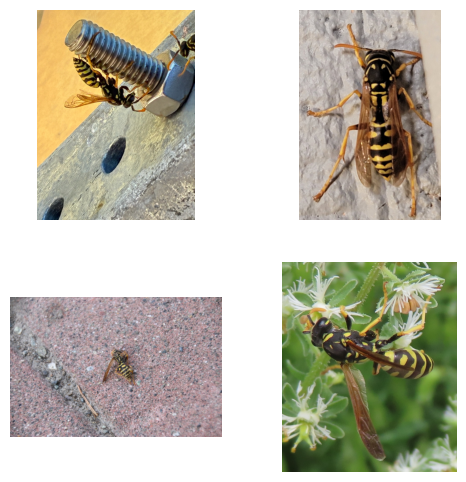

In [4]:
plt.figure(figsize=(6,6))

plt.subplot(221)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(222)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(223)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(224)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]));

Define Batch size

In [15]:
batch_size = 32

## B - <a name="generateurs"></a> Data Generators



In [6]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   )

test_data_generator  = ImageDataGenerator(rescale = 1./255)
data_generator  = ImageDataGenerator(rescale = 1./255)

- (d) Implement ```training_data```, ```valid_data``` splits


In [7]:
training_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "training", 
                                                   batch_size = batch_size)

validation_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "validation", 
                                                   batch_size = batch_size)

#test_data  = test_data_generator.flow_from_directory(directory = spec_dir,
#                                                   target_size = (224, 224),
#                                                   class_mode = 'binary',
#                                                   batch_size = batch_size)


Found 10989 images belonging to 127 classes.
Found 2726 images belonging to 127 classes.


# II - <a name="classif"></a> Classification



In [20]:
# Model MobileNet
base_model = MobileNet(weights='imagenet', include_top=False)

# Freezer les couches
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model) # Ajout du modèl
model.add(GlobalAveragePooling2D())
model.add(Dropout(rate=0.2))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(127, activation='softmax'))

/tmp/ipykernel_228807/1184970024.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False)


In [17]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 4,
                                         mode = 'min',
                                         restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience=4,
                                         factor=0.5,
                                         verbose=2,
                                         mode='max',
                                         min_lr = 1e-10)

In [10]:
optimizer = Adam(learning_rate=0.0001) 

In [11]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

class AveragePrecisionCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator, num_classes=127):
        super().__init__()
        self.val_generator = val_generator
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        for i in range(len(self.val_generator)):
            x_batch, y_batch = self.val_generator[i]  # y_batch: shape (batch_size,)
            preds = self.model.predict(x_batch, verbose=0)  # preds: shape (batch_size, num_classes)

            y_true.extend(y_batch)
            y_pred.extend(preds)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # One-hot encode y_true to match y_pred's shape
        y_true_onehot = label_binarize(y_true, classes=range(self.num_classes))

        # Compute average precision per class
        aps = []
        for i in range(self.num_classes):
            ap = average_precision_score(y_true_onehot[:, i], y_pred[:, i])
            aps.append(ap)

        macro_ap = np.mean(aps)
        print(f"\nEpoch {epoch + 1}: val_average_precision = {macro_ap:.4f}")
        logs = logs or {}
        logs['val_average_precision'] = macro_ap


In [12]:
ap_callback = AveragePrecisionCallback(val_generator=validation_data)

In [13]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit(training_data, validation_data=validation_data, epochs=30, 
                    callbacks=[ap_callback,lr_plateau])

Epoch 1/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1760994986.073686  229164 service.cc:148] XLA service 0x7a6dbc01d080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760994986.073706  229164 service.cc:156]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
I0000 00:00:1760994986.073709  229164 service.cc:156]   StreamExecutor device (1): Quadro RTX 8000, Compute Capability 7.5
2025-10-20 23:16:26.145046: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I00

667/687 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.0319 - loss: 4.7949

E0000 00:00:1760995046.604806  229164 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760995046.728562  229164 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760995049.365823  229164 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760995049.504426  229164 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760995049.626947  229164 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.0326 - loss: 4.7892

E0000 00:00:1760995067.840224  229161 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760995067.964045  229161 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760995070.507007  229161 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760995070.643712  229161 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760995070.765859  229161 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_average_precision = 0.0855
687/687 ━━━━━━━━━━━━━━━━━━━━ 117s 159ms/step - accuracy: 0.0566 - loss: 4.5930 - val_accuracy: 0.1222 - val_loss: 4.1107 - val_average_precision: 0.0855 - learning_rate: 1.0000e-04
Epoch 2/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:22 120ms/step - accuracy: 0.0000e+00 - loss: 4.4319

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.1360 - loss: 3.9613
Epoch 2: val_average_precision = 0.1742
687/687 ━━━━━━━━━━━━━━━━━━━━ 91s 132ms/step - accuracy: 0.1612 - loss: 3.8015 - val_accuracy: 0.2355 - val_loss: 3.3547 - val_average_precision: 0.1742 - learning_rate: 1.0000e-04
Epoch 3/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:46 156ms/step - accuracy: 0.1875 - loss: 3.3744

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2391 - loss: 3.2534
Epoch 3: val_average_precision = 0.2399
687/687 ━━━━━━━━━━━━━━━━━━━━ 93s 136ms/step - accuracy: 0.2493 - loss: 3.1855 - val_accuracy: 0.2986 - val_loss: 2.9759 - val_average_precision: 0.2399 - learning_rate: 1.0000e-04
Epoch 4/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:39 145ms/step - accuracy: 0.3750 - loss: 2.8131

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3092 - loss: 2.8547
Epoch 4: val_average_precision = 0.2651
687/687 ━━━━━━━━━━━━━━━━━━━━ 95s 138ms/step - accuracy: 0.3104 - loss: 2.8166 - val_accuracy: 0.3309 - val_loss: 2.7655 - val_average_precision: 0.2651 - learning_rate: 1.0000e-04
Epoch 5/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:34 137ms/step - accuracy: 0.2500 - loss: 2.7893

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3623 - loss: 2.5784
Epoch 5: val_average_precision = 0.2882
687/687 ━━━━━━━━━━━━━━━━━━━━ 95s 139ms/step - accuracy: 0.3604 - loss: 2.5628 - val_accuracy: 0.3500 - val_loss: 2.6252 - val_average_precision: 0.2882 - learning_rate: 1.0000e-04
Epoch 6/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:41 147ms/step - accuracy: 0.4375 - loss: 2.3466

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3980 - loss: 2.3620
Epoch 6: val_average_precision = 0.3113
687/687 ━━━━━━━━━━━━━━━━━━━━ 95s 138ms/step - accuracy: 0.3981 - loss: 2.3615 - val_accuracy: 0.3617 - val_loss: 2.5441 - val_average_precision: 0.3113 - learning_rate: 1.0000e-04
Epoch 7/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:14 108ms/step - accuracy: 0.2500 - loss: 2.5577

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4325 - loss: 2.2399
Epoch 7: val_average_precision = 0.3162
687/687 ━━━━━━━━━━━━━━━━━━━━ 95s 138ms/step - accuracy: 0.4291 - loss: 2.2298 - val_accuracy: 0.3595 - val_loss: 2.5038 - val_average_precision: 0.3162 - learning_rate: 1.0000e-04
Epoch 8/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:40 146ms/step - accuracy: 0.3125 - loss: 2.3297

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4564 - loss: 2.0974
Epoch 8: val_average_precision = 0.3346
687/687 ━━━━━━━━━━━━━━━━━━━━ 93s 135ms/step - accuracy: 0.4560 - loss: 2.0898 - val_accuracy: 0.3793 - val_loss: 2.4409 - val_average_precision: 0.3346 - learning_rate: 1.0000e-04
Epoch 9/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:39 145ms/step - accuracy: 0.5625 - loss: 2.1473

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4865 - loss: 1.9559
Epoch 9: val_average_precision = 0.3404
687/687 ━━━━━━━━━━━━━━━━━━━━ 93s 135ms/step - accuracy: 0.4780 - loss: 1.9906 - val_accuracy: 0.3833 - val_loss: 2.4254 - val_average_precision: 0.3404 - learning_rate: 1.0000e-04
Epoch 10/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:30 132ms/step - accuracy: 0.4375 - loss: 2.0729

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5026 - loss: 1.8997
Epoch 10: val_average_precision = 0.3457
687/687 ━━━━━━━━━━━━━━━━━━━━ 94s 136ms/step - accuracy: 0.5021 - loss: 1.9004 - val_accuracy: 0.3914 - val_loss: 2.3948 - val_average_precision: 0.3457 - learning_rate: 1.0000e-04
Epoch 11/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5178 - loss: 1.8136
Epoch 11: val_average_precision = 0.3485
687/687 ━━━━━━━━━━━━━━━━━━━━ 94s 137ms/step - accuracy: 0.5160 - loss: 1.8184 - val_accuracy: 0.4002 - val_loss: 2.3797 - val_average_precision: 0.3485 - learning_rate: 1.0000e-04
Epoch 12/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:38 144ms/step - accuracy: 0.2500 - loss: 2.8342

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5504 - loss: 1.6728
Epoch 12: val_average_precision = 0.3595
687/687 ━━━━━━━━━━━━━━━━━━━━ 94s 136ms/step - accuracy: 0.5335 - loss: 1.7245 - val_accuracy: 0.4006 - val_loss: 2.3547 - val_average_precision: 0.3595 - learning_rate: 1.0000e-04
Epoch 13/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:28 129ms/step - accuracy: 0.2500 - loss: 2.0495

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5516 - loss: 1.6373
Epoch 13: val_average_precision = 0.3443
687/687 ━━━━━━━━━━━━━━━━━━━━ 94s 136ms/step - accuracy: 0.5506 - loss: 1.6496 - val_accuracy: 0.4043 - val_loss: 2.3425 - val_average_precision: 0.3443 - learning_rate: 1.0000e-04
Epoch 14/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:20 117ms/step - accuracy: 0.6250 - loss: 1.3336

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5794 - loss: 1.5670
Epoch 14: val_average_precision = 0.3593
687/687 ━━━━━━━━━━━━━━━━━━━━ 92s 135ms/step - accuracy: 0.5714 - loss: 1.5895 - val_accuracy: 0.4112 - val_loss: 2.3560 - val_average_precision: 0.3593 - learning_rate: 1.0000e-04
Epoch 15/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:28 128ms/step - accuracy: 0.5625 - loss: 1.2985

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5949 - loss: 1.4865
Epoch 15: val_average_precision = 0.3572
687/687 ━━━━━━━━━━━━━━━━━━━━ 93s 135ms/step - accuracy: 0.5856 - loss: 1.5156 - val_accuracy: 0.4028 - val_loss: 2.3359 - val_average_precision: 0.3572 - learning_rate: 1.0000e-04
Epoch 16/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:21 119ms/step - accuracy: 0.6875 - loss: 1.5312

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6033 - loss: 1.4456
Epoch 16: val_average_precision = 0.3506
687/687 ━━━━━━━━━━━━━━━━━━━━ 95s 138ms/step - accuracy: 0.6001 - loss: 1.4550 - val_accuracy: 0.4094 - val_loss: 2.3419 - val_average_precision: 0.3506 - learning_rate: 1.0000e-04
Epoch 17/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:56 170ms/step - accuracy: 0.8125 - loss: 1.0291

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6310 - loss: 1.3500
Epoch 17: val_average_precision = 0.3635
687/687 ━━━━━━━━━━━━━━━━━━━━ 91s 132ms/step - accuracy: 0.6174 - loss: 1.3979 - val_accuracy: 0.4072 - val_loss: 2.3352 - val_average_precision: 0.3635 - learning_rate: 1.0000e-04
Epoch 18/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:26 127ms/step - accuracy: 0.5625 - loss: 1.7453

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6352 - loss: 1.3100
Epoch 18: val_average_precision = 0.3603
687/687 ━━━━━━━━━━━━━━━━━━━━ 94s 136ms/step - accuracy: 0.6292 - loss: 1.3435 - val_accuracy: 0.4123 - val_loss: 2.3520 - val_average_precision: 0.3603 - learning_rate: 1.0000e-04
Epoch 19/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:15 111ms/step - accuracy: 0.6250 - loss: 0.9733

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6445 - loss: 1.2994
Epoch 19: val_average_precision = 0.3664
687/687 ━━━━━━━━━━━━━━━━━━━━ 94s 137ms/step - accuracy: 0.6451 - loss: 1.2896 - val_accuracy: 0.4098 - val_loss: 2.3469 - val_average_precision: 0.3664 - learning_rate: 1.0000e-04
Epoch 20/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:46 155ms/step - accuracy: 0.7500 - loss: 0.8246

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6599 - loss: 1.1972
Epoch 20: val_average_precision = 0.3618

Epoch 20: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
687/687 ━━━━━━━━━━━━━━━━━━━━ 93s 135ms/step - accuracy: 0.6540 - loss: 1.2252 - val_accuracy: 0.4050 - val_loss: 2.3595 - val_average_precision: 0.3618 - learning_rate: 1.0000e-04
Epoch 21/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:41 148ms/step - accuracy: 0.6250 - loss: 1.2390

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.6867 - loss: 1.1245
Epoch 21: val_average_precision = 0.3594
687/687 ━━━━━━━━━━━━━━━━━━━━ 96s 139ms/step - accuracy: 0.6869 - loss: 1.1320 - val_accuracy: 0.4230 - val_loss: 2.3261 - val_average_precision: 0.3594 - learning_rate: 5.0000e-05
Epoch 22/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:37 142ms/step - accuracy: 0.7500 - loss: 0.9009

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7055 - loss: 1.0834
Epoch 22: val_average_precision = 0.3644
687/687 ━━━━━━━━━━━━━━━━━━━━ 94s 136ms/step - accuracy: 0.6948 - loss: 1.1052 - val_accuracy: 0.4178 - val_loss: 2.3273 - val_average_precision: 0.3644 - learning_rate: 5.0000e-05
Epoch 23/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:31 134ms/step - accuracy: 0.6875 - loss: 1.1039

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6981 - loss: 1.0742
Epoch 23: val_average_precision = 0.3606
687/687 ━━━━━━━━━━━━━━━━━━━━ 95s 138ms/step - accuracy: 0.6991 - loss: 1.0781 - val_accuracy: 0.4186 - val_loss: 2.3264 - val_average_precision: 0.3606 - learning_rate: 5.0000e-05
Epoch 24/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:38 143ms/step - accuracy: 0.6875 - loss: 0.9321

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7050 - loss: 1.0486
Epoch 24: val_average_precision = 0.3635
687/687 ━━━━━━━━━━━━━━━━━━━━ 95s 139ms/step - accuracy: 0.7012 - loss: 1.0718 - val_accuracy: 0.4274 - val_loss: 2.3118 - val_average_precision: 0.3635 - learning_rate: 5.0000e-05
Epoch 25/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:43 151ms/step - accuracy: 0.6875 - loss: 1.0125

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7100 - loss: 1.0435
Epoch 25: val_average_precision = 0.3627
687/687 ━━━━━━━━━━━━━━━━━━━━ 95s 138ms/step - accuracy: 0.7083 - loss: 1.0455 - val_accuracy: 0.4211 - val_loss: 2.3289 - val_average_precision: 0.3627 - learning_rate: 5.0000e-05
Epoch 26/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:32 135ms/step - accuracy: 0.8750 - loss: 0.7381

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7185 - loss: 0.9966
Epoch 26: val_average_precision = 0.3589
687/687 ━━━━━━━━━━━━━━━━━━━━ 94s 136ms/step - accuracy: 0.7148 - loss: 1.0144 - val_accuracy: 0.4182 - val_loss: 2.3335 - val_average_precision: 0.3589 - learning_rate: 5.0000e-05
Epoch 27/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:46 156ms/step - accuracy: 0.8125 - loss: 0.9868

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7282 - loss: 0.9789
Epoch 27: val_average_precision = 0.3597

Epoch 27: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
687/687 ━━━━━━━━━━━━━━━━━━━━ 93s 135ms/step - accuracy: 0.7224 - loss: 0.9938 - val_accuracy: 0.4156 - val_loss: 2.3336 - val_average_precision: 0.3597 - learning_rate: 5.0000e-05
Epoch 28/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:31 133ms/step - accuracy: 0.6250 - loss: 1.0932

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7335 - loss: 0.9441
Epoch 28: val_average_precision = 0.3638
687/687 ━━━━━━━━━━━━━━━━━━━━ 93s 136ms/step - accuracy: 0.7351 - loss: 0.9457 - val_accuracy: 0.4230 - val_loss: 2.3249 - val_average_precision: 0.3638 - learning_rate: 2.5000e-05
Epoch 29/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:35 139ms/step - accuracy: 0.6250 - loss: 0.7665

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7413 - loss: 0.9127
Epoch 29: val_average_precision = 0.3670
687/687 ━━━━━━━━━━━━━━━━━━━━ 95s 138ms/step - accuracy: 0.7396 - loss: 0.9289 - val_accuracy: 0.4175 - val_loss: 2.3287 - val_average_precision: 0.3670 - learning_rate: 2.5000e-05
Epoch 30/30
  1/687 ━━━━━━━━━━━━━━━━━━━━ 1:32 135ms/step - accuracy: 0.5625 - loss: 1.1016

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7447 - loss: 0.9281
Epoch 30: val_average_precision = 0.3653

Epoch 30: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
687/687 ━━━━━━━━━━━━━━━━━━━━ 92s 134ms/step - accuracy: 0.7464 - loss: 0.9228 - val_accuracy: 0.4244 - val_loss: 2.3342 - val_average_precision: 0.3653 - learning_rate: 2.5000e-05


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


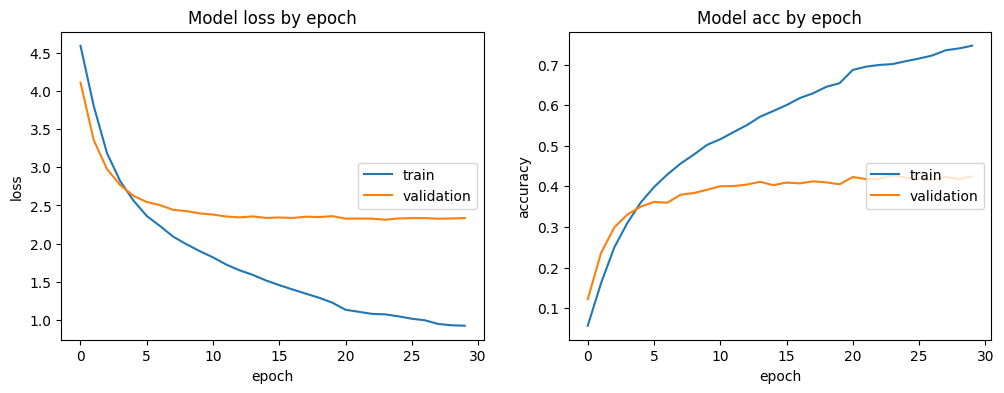

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
plt.show()

In [18]:
model.save('../models/model_127_species_exp1.h5')